In [1]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
from datetime import datetime, timedelta, date, time

def parse_dt(dt, tm):
    year=dt[0:4]
    month=dt[4:6]
    day=dt[6:8]
    minute=tm[2:4]
    hour=tm[0:2]
    return datetime(year=int(year), month=int(month), day=int(day),\
                   hour=int(hour), minute=int(minute), second=0)

def parse_date(dt):
    year=dt[0:4]
    month=dt[4:6]
    day=dt[6:8]
    return date(year=int(year), month=int(month), day=int(day))

def parse_time(tm):
    minute=tm[2:4]
    hour=tm[0:2]
    return time(hour=int(hour), minute=int(minute), second=0)

In [3]:
alpha_col=["date", "time", "symbol","mid","const","sector","industry","sizeAlpha","tradeAlpha"]
data=pd.read_csv("data/alpha.log", header=None, skipinitialspace=True, names=alpha_col,\
                       engine='c', usecols=range(0,9),\
                       dtype={'date': np.str, 'time': np.str, 'symbol': np.str, 'const': np.float32,
                             'sector': np.str, 'industry': np.str, 'sizeAlpha': np.float32, 'tradeAlpha': np.float32},\
#                        parse_dates={'datetime': ['date', 'time']}, date_parser=parse_dt,
                       )

In [4]:
data['date']=data['date'].apply(parse_date)
data['time']=data['time'].apply(parse_time)

In [5]:
data['logmid']=np.log(data['mid'])

In [6]:
data = data.loc[data.mid>0]

In [7]:
import fnmatch


stocks=data.symbol.unique()

in_dir = "./data/close/"
fname='20130103.close'
thisday = parse_date(fname.strip('.close'))
thisdf = pd.read_csv(in_dir+fname, delimiter='|')

thisdf = thisdf.loc[thisdf.TICKER.apply(lambda x: x in stocks)]

newstocks = thisdf.TICKER.unique()

In [8]:
timestart = time(hour=15, minute=29)
timestop = time(hour=16, minute=1)

grouped = data.groupby('symbol')
data_stock = {stock: pd.DataFrame for stock in newstocks}
data_train = {stock: pd.DataFrame for stock in newstocks}
for stock in newstocks:
    data_stock[stock] = grouped.get_group(stock)
    data_train[stock] = data_stock[stock].loc[(data_stock[stock].time>timestart)&(data_stock[stock].time<timestop)]

In [9]:
import os
days = data_train.get('A').date.unique()
close = pd.DataFrame(columns=days, index=newstocks, dtype=np.float32)

in_dir = "./data/close/"
for file in os.listdir(in_dir):
    if fnmatch.fnmatch(file, '*.close'):
        thisday = parse_date(file.strip('.close'))
        thisdf = pd.read_csv(in_dir+file, delimiter='|')
        thisdf = thisdf.loc[thisdf.TICKER.apply(lambda x: x in newstocks)]
        for stock in thisdf.TICKER:
            close.loc[stock, thisday]=thisdf.loc[thisdf.TICKER==stock].ADJ_CLOSE.values[0]
#         print thisday, thisdf.shape
#         close[thisday] = thisdf.ADJ_CLOSE

In [10]:
close.head()

,2013-01-02,2013-01-03,2013-01-04,2013-01-07,2013-01-08,2013-01-09,2013-01-10,2013-01-11,2013-01-14,2013-01-15,...,2013-03-15,2013-03-18,2013-03-19,2013-03-20,2013-03-21,2013-03-22,2013-03-25,2013-03-26,2013-03-27,2013-03-28
A,40.939999,41.880001,42.029999,42.860001,42.549999,42.209999,43.349998,43.669998,43.430000,43.540001,...,43.320000,43.009998,42.549999,42.000000,42.700001,41.650002,41.250000,41.130001,41.820000,41.970001
AA,8.680000,8.990000,9.070000,9.260000,9.100000,9.100000,9.080000,8.970000,8.940000,8.920000,...,8.550000,8.630000,8.560000,8.480000,8.540000,8.450000,8.450000,8.420000,8.420000,8.490000
AAN,28.280001,28.700001,28.780001,29.110001,28.740000,28.790001,29.230000,28.920000,29.030001,29.350000,...,28.450001,28.350000,28.530001,28.549999,28.870001,28.350000,28.400000,28.540001,28.639999,28.639999
AAP,72.349998,72.489998,72.489998,73.620003,73.370003,72.169998,72.389999,71.760002,72.290001,72.580002,...,77.669998,79.570000,80.699997,80.010002,80.220001,80.029999,79.809998,80.529999,81.599998,81.639999
AAPL,532.172974,549.030029,542.096008,527.000000,523.900024,525.309998,517.099976,523.510010,520.299988,501.750000,...,432.500000,443.660004,455.720001,454.489990,452.079987,452.730011,461.910004,463.579987,461.135986,452.079987


In [11]:
result = {stock: pd.DataFrame(columns=['day', 'signal', 'close', 'open', 'price15', 'return0', 'return15' ]) for stock in newstocks}
bad_stock=[]
for stock in newstocks:
    thisdf = data_train.get(stock)
    va = thisdf.groupby('date').mid.std()
    me = thisdf.groupby('date').mid.mean()
    signal = np.log(va/me).values
    try:
        result.get(stock)['day'] = days
        result.get(stock)['close'] = close.ix[stock].values
        result.get(stock)['signal'] = signal
    except:
        print stock
        bad_stock.append(stock)
        

AAN
AAWW
ABCO
ABG
ABMD
ACAD
ACHC
ACOR
ACTG
AEGR
AER
AF
AFFY
AH
AIRM
AKR
AKRX
AL
ALDW
ALJ
ALLT
ALNY
ALR
AMTG
ANGI
APO
ARCP
AREX
ASCA
ATLS
ATR
ATU
AUXL
AVG
AWAY
AZPN
BANR
BAS
BBEP
BBVA
BCEI
BDBD
BDC
BEE
BGG
BIP
BJRI
BKE
BKU
BKW
BLOX
BNNY
BOH
BPT
BSAC
BSFT
BYD
CASY
CBB
CBT
CFFN
CHU
CJES
CKH
CLC
CLDX
CLMT
CLSN
CLWR
CM
CMO
CNL
CPL
CPNO
CPWR
CSGP
CSH
CVA
CVG
CWH
CXS
CYBX
CZR
DAR
DGI
DIN
DLB
DMND
DOLE
DPM
DRYS
DUF
DVAX
DYN
EBIX
EEQ
EGP
ELS
EME
ENH
ENI
ENS
EPHC
EPR
EQY
ERF
ESC
ESI
ET
ETH
EVER
EVR
EXEL
EXH
EZCH
FBR
FCN
FET
FIVE
FMS
FNGN
FNV
FOE
FR
FSC
FSL
FTE
FUL
FULT
GBX
GDP
GEF
GEL
GEOS
GFA
GGC
GLF
GLUU
GMT
GOL
GPK
GRFS
GRT
GTAT
GTI
GWRE
GY
H
HAE
HBHC
HE
HEK
HHC
HLS
HOTT
HR
HRC
HSC
HTA
HTSI
HW
IDTI
IEP
IHG
IM
IMGN
IMO
IN
INVN
INXN
IPI
IRWD
ITMN
ITRI
JACK
JCOM
JIVE
JOE
JW/A
KAR
KCG
KEP
KERX
KFN
KOF
KOS
KRO
KT
LAD
LANC
LEAP
LFC
LFL
LMCA
LNN
LOGM
LOPE
LPI
LPL
LPLA
LYV
MAIN
MANH
MBFI
MCY
MDP
MEMP
MFRM
MGLN
MHO
MIC
MKL
MKTX
MM
MMS
MNKD
MNRO
MOH
MOLX
MRC
MSCC
MSTR
MTG
MTL
MTN
MTU
MUSA
MWW
MX
NEU
NI

In [12]:
len(bad_stock)

385

In [13]:
newstocks=list(newstocks)
for s in bad_stock:
    try:
        newstocks.remove(s)
    except:
        print s

In [14]:
len(newstocks)

1304

In [15]:
for stock in newstocks:
    result.get(stock)['price30'] = np.zeros(days.size)
    result.get(stock)['price60'] = np.zeros(days.size)
    result.get(stock)['new_close'] = np.zeros(days.size)
    result.get(stock)['return30'] = np.zeros(days.size)
    result.get(stock)['return60'] = np.zeros(days.size)
    result.get(stock)['return_close'] = np.zeros(days.size)

In [16]:
timeopen=time(hour=9, minute=45)
time15 = time(hour=10, minute=0)
time30 = time(hour=10, minute=15)
time60 = time(hour=10, minute=45)
time_close= time(hour=16, minute=30)

for stock in newstocks:
    thisdf = data_stock[stock]
    daysdf = thisdf.groupby('date')
    result.get(stock)['open']=[daydf[1].iloc[0].mid for daydf in daysdf]
    result.get(stock)['price15']=[daydf[1].iloc[15].mid for daydf in daysdf]
    result.get(stock)['price30']=[daydf[1].iloc[30].mid for daydf in daysdf]
    result.get(stock)['price60']=[daydf[1].iloc[60].mid for daydf in daysdf]
    result.get(stock)['new_close']=[daydf[1].iloc[375].mid for daydf in daysdf]

In [17]:
for stock in newstocks:
    thisdf = result.get(stock)
    result.get(stock)['return0'] = np.log(thisdf['open']/thisdf['close'])
    result.get(stock)['return15'] = np.log(thisdf['price15']/thisdf['close'])
    result.get(stock)['return30'] = np.log(thisdf['price30']/thisdf['close'])
    result.get(stock)['return60'] = np.log(thisdf['price60']/thisdf['close'])
    result.get(stock)['return_close'] = np.log(thisdf['new_close']/thisdf['close'])

In [18]:
result['A'].head(2)

,day,signal,close,open,price15,return0,return15,price30,price60,new_close,return30,return60,return_close
0,2013-01-02,-5.863329,40.939999,41.655,41.765,0.017314,0.019951,41.730,41.575,41.875,0.019113,0.015391,0.022581
1,2013-01-03,-6.552647,41.880001,41.725,41.745,-0.003708,-0.003229,41.685,41.655,42.025,-0.004667,-0.005387,0.003456


In [19]:
for stock in newstocks:
    result.get(stock)['return15_open'] = np.zeros(days.size)
    result.get(stock)['return30_open'] = np.zeros(days.size)
    result.get(stock)['return60_open'] = np.zeros(days.size)
    result.get(stock)['returnclose_open'] = np.zeros(days.size)

In [20]:
for stock in newstocks:
    thisdf = result.get(stock)
    result.get(stock)['return15_open'] = np.log(thisdf['price15']/thisdf['open'])
    result.get(stock)['return30_open'] = np.log(thisdf['price30']/thisdf['open'])
    result.get(stock)['return60_open'] = np.log(thisdf['price60']/thisdf['open'])
    result.get(stock)['returnclose_open'] = np.log(thisdf['new_close']/thisdf['open'])

In [21]:
result['A'].head(2)

,day,signal,close,open,price15,return0,return15,price30,price60,new_close,return30,return60,return_close,return15_open,return30_open,return60_open,returnclose_open
0,2013-01-02,-5.863329,40.939999,41.655,41.765,0.017314,0.019951,41.730,41.575,41.875,0.019113,0.015391,0.022581,0.002637,0.001799,-0.001922,0.005268
1,2013-01-03,-6.552647,41.880001,41.725,41.745,-0.003708,-0.003229,41.685,41.655,42.025,-0.004667,-0.005387,0.003456,0.000479,-0.000959,-0.001679,0.007164


In [22]:
for stock in newstocks:
    result.get(stock).drop(0, axis=0, inplace=True)

In [23]:
result['A'].head()

,day,signal,close,open,price15,return0,return15,price30,price60,new_close,return30,return60,return_close,return15_open,return30_open,return60_open,returnclose_open
1,2013-01-03,-6.552647,41.880001,41.725,41.745,-0.003708,-0.003229,41.685,41.655,42.025,-0.004667,-0.005387,0.003456,0.000479,-0.000959,-0.001679,0.007164
2,2013-01-04,-7.505401,42.029999,41.905,42.025,-0.002978,-0.000119,42.255,42.305,42.855,0.005339,0.006522,0.019439,0.002860,0.008318,0.009500,0.022417
3,2013-01-07,-7.159649,42.860001,42.595,42.785,-0.006202,-0.001751,42.575,42.535,42.560,-0.006672,-0.007612,-0.007024,0.004451,-0.000470,-0.001410,-0.000822
4,2013-01-08,-6.640947,42.549999,42.785,42.680,0.005508,0.003051,42.655,42.490,42.220,0.002465,-0.001411,-0.007786,-0.002457,-0.003043,-0.006919,-0.013294
5,2013-01-09,-7.239555,42.209999,42.695,43.165,0.011425,0.022373,43.385,43.185,43.335,0.027457,0.022836,0.026303,0.010948,0.016032,0.011411,0.014879


In [24]:
ret0_max = np.percentile(np.array([result.get(stock).return0.max() for stock in newstocks]), 99.5)
ret0_min = np.percentile(np.array([result.get(stock).return0.min() for stock in newstocks]), 0.5)
ret15_max = np.percentile(np.array([result.get(stock).return15.max() for stock in newstocks]), 99.5)
ret15_min = np.percentile(np.array([result.get(stock).return15.min() for stock in newstocks]), 0.5)
ret30_max = np.percentile(np.array([result.get(stock).return30.max() for stock in newstocks]), 99.5)
ret30_min = np.percentile(np.array([result.get(stock).return30.min() for stock in newstocks]), 0.5)
ret60_max = np.percentile(np.array([result.get(stock).return60.max() for stock in newstocks]), 99.5)
ret60_min = np.percentile(np.array([result.get(stock).return60.min() for stock in newstocks]), 0.5)
retclose_max = np.percentile(np.array([result.get(stock).return_close.max() for stock in newstocks]), 99.5)
retclose_min = np.percentile(np.array([result.get(stock).return_close.min() for stock in newstocks]), 0.5)
ret15_open_max = np.percentile(np.array([result.get(stock).return15_open.max() for stock in newstocks]), 99.5)
ret15_open_min = np.percentile(np.array([result.get(stock).return15_open.min() for stock in newstocks]), 0.5)
ret30_open_max = np.percentile(np.array([result.get(stock).return30_open.max() for stock in newstocks]), 99.5)
ret30_open_min = np.percentile(np.array([result.get(stock).return30_open.min() for stock in newstocks]), 0.5)
ret60_open_max = np.percentile(np.array([result.get(stock).return60_open.max() for stock in newstocks]), 99.5)
ret60_open_min = np.percentile(np.array([result.get(stock).return60_open.min() for stock in newstocks]), 0.5)
retclose_open_max = np.percentile(np.array([result.get(stock).returnclose_open.max() for stock in newstocks]), 99.5)
retclose_open_min = np.percentile(np.array([result.get(stock).returnclose_open.min() for stock in newstocks]), 0.5)
print "ret0: {}, {}".format(ret15_max, ret0_min)
print "ret15: {}, {}".format(ret15_max, ret15_min)
print "ret30: {}, {}".format(ret30_max, ret30_min)
print "ret60: {}, {}".format(ret60_max, ret60_min)
print "ret15_open: {}, {}".format(ret15_open_max, ret15_open_min)
print "ret30_open: {}, {}".format(ret30_open_max, ret30_open_min)
print "ret60_open: {}, {}".format(ret60_open_max, ret60_open_min)
print "retclose_open: {}, {}".format(retclose_open_max, retclose_open_min)

ret0: 0.182685777774, -0.217935398286
ret15: 0.182685777774, -0.212623026066
ret30: 0.183559763136, -0.224926608738
ret60: 0.182908597001, -0.222533921595
ret15_open: 0.0466815319113, -0.0429643713758
ret30_open: 0.0625497212207, -0.0537544888709
ret60_open: 0.0671553823545, -0.0686537378498
retclose_open: 0.103210139128, -0.121340765403


In [25]:
result['A'].mean()

signal              -7.089145
close               43.192712
open                43.176271
price15             43.202966
return0             -0.000391
return15             0.000227
price30             43.200593
price60             43.203305
new_close           43.195593
return30             0.000175
return60             0.000246
return_close         0.000069
return15_open        0.000619
return30_open        0.000567
return60_open        0.000638
returnclose_open     0.000461
dtype: float64

In [63]:
# thisdf = data_stock.get('SAN').loc[data_stock.get('SAN').date==date(2013,3,7)]
# np.log(thisdf.mid.std()/thisdf.mid.mean())
for stock in newstocks:
    thisdf = data_train.get(stock)
    va = thisdf.groupby('date').mid.std()
    me = thisdf.groupby('date').mid.mean()
    signal = np.log(va/me)
    signal = np.maximum(-15, signal)
    result.get(stock)['signal'] = signal[0:-1].values

In [61]:
result.get('A').head(2)
# len(result.get('A')['signal'].index)
# signal[0:-1].values.size
# len(signal[0:-1].values)

,day,signal,close,open,price15,return0,return15,price30,price60,new_close,return30,return60,return_close,return15_open,return30_open,return60_open,returnclose_open
1,2013-01-03,-5.863329,41.880001,41.725,41.745,-0.003708,-0.003229,41.685,41.655,42.025,-0.004667,-0.005387,0.003456,0.000479,-0.000959,-0.001679,0.007164
2,2013-01-04,-6.552647,42.029999,41.905,42.025,-0.002978,-0.000119,42.255,42.305,42.855,0.005339,0.006522,0.019439,0.002860,0.008318,0.009500,0.022417


In [64]:
perc = [1, 5, 50, 95, 99]
for p in perc:
    print np.percentile(pd.concat([result.get(stock).signal for stock in newstocks]), p) 

-8.4400168341
-7.99343158271
-7.05079212347
-5.96244256732
-5.41796421072


In [68]:
toplot = {stock: pd.DataFrame for stock in newstocks}
for stock in newstocks:
    thisdf = result[stock]
    toplot[stock] = thisdf.loc[(thisdf.return0<0.18)&(thisdf.return0>-0.21) \
                              &(thisdf.signal<-4)&(thisdf.signal>-10)\
                              ]
    

In [69]:
perc = [0.5, 5, 50, 95, 99.5]
for p in perc:
    print np.percentile(pd.concat([toplot.get(stock).signal for stock in newstocks]), p) 

-8.59906777883
-7.98602670647
-7.05102339884
-5.9712416566
-5.25430232664


In [70]:
print pd.concat([toplot.get(stock).signal for stock in newstocks]).min(),\
pd.concat([toplot.get(stock).signal for stock in newstocks]).max()

-9.97656081493 -4.04855520833


In [74]:
# Alphabins = np.linspace(pd.concat([toplot.get(stock).signal for stock in newstocks]).min(),\
#                         pd.concat([toplot.get(stock).signal for stock in newstocks]).max(), 22)
all_sigs = pd.concat([toplot.get(stock).signal for stock in newstocks])
Alphabins=[all_sigs.quantile(0+1.0/22.0*i) for i in range(22)]
Alphabins[0]-=0.1
Alphabins[-1]+=0.1
for stock in newstocks:
    toplot.get(stock)['signalbin']=pd.cut(toplot[stock].signal, Alphabins, labels=range(-10,11))
    

/Users/cong/.pyenv/versions/anaconda-2.3.0/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [75]:
toplot['A'].head(2)

,day,signal,close,open,price15,return0,return15,price30,price60,new_close,return30,return60,return_close,return15_open,return30_open,return60_open,returnclose_open,signalbin
1,2013-01-03,-5.863329,41.880001,41.725,41.745,-0.003708,-0.003229,41.685,41.655,42.025,-0.004667,-0.005387,0.003456,0.000479,-0.000959,-0.001679,0.007164,10
2,2013-01-04,-6.552647,42.029999,41.905,42.025,-0.002978,-0.000119,42.255,42.305,42.855,0.005339,0.006522,0.019439,0.002860,0.008318,0.009500,0.022417,7


In [76]:
size_a = np.zeros(21);
ret_mean0 = np.zeros(21); ret_mean15 = np.zeros(21); ret_mean30 = np.zeros(21); ret_mean60 = np.zeros(21)
ret_mean15_open = np.zeros(21); ret_mean30_open = np.zeros(21); ret_mean60_open = np.zeros(21); ret_meanclose_open = np.zeros(21)
for stock in newstocks:
    size_a += toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean0 += toplot[stock].groupby('signalbin')['return0'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15 += toplot[stock].groupby('signalbin')['return15'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30 += toplot[stock].groupby('signalbin')['return30'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60 += toplot[stock].groupby('signalbin')['return60'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15_open += toplot[stock].groupby('signalbin')['return15_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30_open += toplot[stock].groupby('signalbin')['return30_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60_open += toplot[stock].groupby('signalbin')['return60_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_meanclose_open += toplot[stock].groupby('signalbin')['returnclose_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)

In [77]:
ret0 = ret_mean0/size_a*10000
ret15 = ret_mean15/size_a*10000
ret30 = ret_mean30/size_a*10000
ret60 = ret_mean60/size_a*10000
ret15_open = ret_mean15_open/size_a*10000
ret30_open = ret_mean30_open/size_a*10000
ret60_open = ret_mean60_open/size_a*10000
retclose_open = ret_meanclose_open/size_a*10000

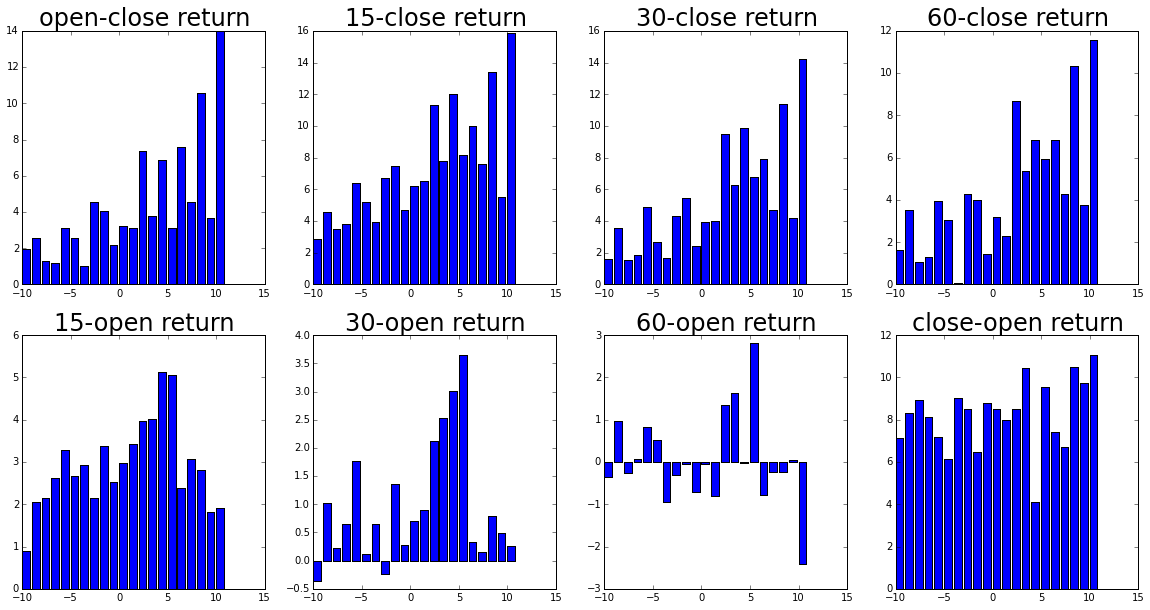

In [81]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20,10))
l1=ax1.bar(np.arange(-10, 11), ret0)
ax1.set_title(r'open-close return', fontsize=24)
l2 = ax2.bar(np.arange(-10, 11), ret15)
ax2.set_title(r'15-close return', fontsize=24)

l3 = ax3.bar(np.arange(-10, 11), ret30)
ax3.set_title(r'30-close return', fontsize=24)

l4=ax4.bar(np.arange(-10, 11), ret60)
ax4.set_title(r'60-close return', fontsize=24)

l5 = ax5.bar(np.arange(-10, 11), ret15_open)
ax5.set_title(r'15-open return', fontsize=24)

l6 = ax6.bar(np.arange(-10, 11), ret30_open)
ax6.set_title(r'30-open return', fontsize=24)

l7 = ax7.bar(np.arange(-10, 11), ret60_open)
ax7.set_title(r'60-open return', fontsize=24)

l8 = ax8.bar(np.arange(-10, 11), retclose_open)
ax8.set_title(r'close-open return', fontsize=24)

## log(last 30min price var/ last 30min price mean)

In [83]:
for stock in newstocks:
    result.get(stock)['signal_30ret'] = np.zeros(days.size-1)

for stock in newstocks:
    logret=np.zeros(days.size); i=0
    daysdf = data_train.get(stock).groupby('date')
    for dt, df in daysdf:
        logret[i]=(df.iloc[-1].logmid-df.iloc[0].logmid)
        i+=1
    result.get(stock)['signal_30ret'] = logret[0:-1]

In [117]:
all_sigs=pd.concat([result.get(stock).signal_30ret for stock in newstocks])
perc = [0.5, 40, 50, 60, 99.5]
for p in perc:
    print np.percentile(all_sigs, p) 

-0.0111740122282
-0.000298685784777
0.000201745100376
0.000784689869811
0.0106999424439


In [86]:
print all_sigs.min(), all_sigs.max()

-0.117613849295 0.105963634826


In [118]:
toplot = {stock: pd.DataFrame for stock in newstocks}
for stock in newstocks:
    thisdf = result[stock]
    toplot[stock] = thisdf.loc[(thisdf.return0<0.18)&(thisdf.return0>-0.21)\
                              &(thisdf.signal_30ret>-0.0112)&(thisdf.signal_30ret<0.0107)\
                              &(thisdf.signal_30ret.abs>0.0002)]

In [119]:
all_sigs=pd.concat([toplot.get(stock).signal_30ret for stock in newstocks])

In [120]:
Alphabins=[all_sigs.quantile(i/22.0) for i in range(22)]

In [121]:
Alphabins[0]-=0.001; Alphabins[-1]+=0.001

In [122]:
for stock in newstocks:
    toplot.get(stock)['signalbin']=pd.cut(toplot[stock].signal_30ret, Alphabins, labels=range(-10,11))


/Users/cong/.pyenv/versions/anaconda-2.3.0/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [123]:
size_a = np.zeros(21);
ret_mean0 = np.zeros(21); ret_mean15 = np.zeros(21); ret_mean30 = np.zeros(21); ret_mean60 = np.zeros(21)
ret_mean15_open = np.zeros(21); ret_mean30_open = np.zeros(21); ret_mean60_open = np.zeros(21); ret_meanclose_open = np.zeros(21)
for stock in newstocks:
    size_a += toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean0 += toplot[stock].groupby('signalbin')['return0'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15 += toplot[stock].groupby('signalbin')['return15'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30 += toplot[stock].groupby('signalbin')['return30'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60 += toplot[stock].groupby('signalbin')['return60'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15_open += toplot[stock].groupby('signalbin')['return15_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30_open += toplot[stock].groupby('signalbin')['return30_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60_open += toplot[stock].groupby('signalbin')['return60_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_meanclose_open += toplot[stock].groupby('signalbin')['returnclose_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)

In [124]:
ret0 = ret_mean0/size_a*10000
ret15 = ret_mean15/size_a*10000
ret30 = ret_mean30/size_a*10000
ret60 = ret_mean60/size_a*10000
ret15_open = ret_mean15_open/size_a*10000
ret30_open = ret_mean30_open/size_a*10000
ret60_open = ret_mean60_open/size_a*10000
retclose_open = ret_meanclose_open/size_a*10000

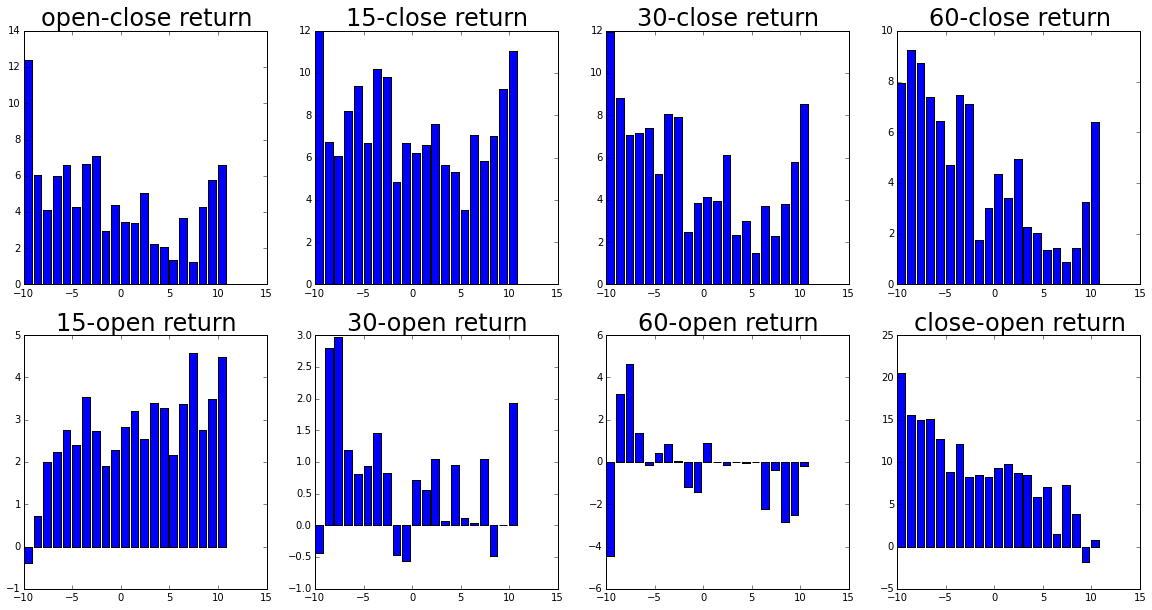

In [125]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20,10))
l1=ax1.bar(np.arange(-10, 11), ret0)
ax1.set_title(r'open-close return', fontsize=24)
l2 = ax2.bar(np.arange(-10, 11), ret15)
ax2.set_title(r'15-close return', fontsize=24)

l3 = ax3.bar(np.arange(-10, 11), ret30)
ax3.set_title(r'30-close return', fontsize=24)

l4=ax4.bar(np.arange(-10, 11), ret60)
ax4.set_title(r'60-close return', fontsize=24)

l5 = ax5.bar(np.arange(-10, 11), ret15_open)
ax5.set_title(r'15-open return', fontsize=24)

l6 = ax6.bar(np.arange(-10, 11), ret30_open)
ax6.set_title(r'30-open return', fontsize=24)

l7 = ax7.bar(np.arange(-10, 11), ret60_open)
ax7.set_title(r'60-open return', fontsize=24)

l8 = ax8.bar(np.arange(-10, 11), retclose_open)
ax8.set_title(r'close-open return', fontsize=24)

## Last 30min log return

In [98]:
for stock in newstocks:
    result.get(stock)['signal_15ret'] = np.zeros(days.size-1)

for stock in newstocks:
    logret=np.zeros(days.size); i=0
    daysdf = data_train.get(stock).groupby('date')
    for dt, df in daysdf:
        logret[i]=(df.iloc[15].logmid-df.iloc[0].logmid)
        i+=1
    result.get(stock)['signal_15ret'] = logret[0:-1]

In [109]:
all_sigs=pd.concat([result.get(stock).signal_15ret for stock in newstocks])
perc = [0.5, 40, 50, 60, 99.5]
for p in perc:
    print np.percentile(all_sigs, p) 

-0.0077393296304
-0.00024294448838
0.0
0.000400560790455
0.00757532144789


In [102]:
print all_sigs.min(), all_sigs.max()

-0.0317823360696 0.0951549444932


In [110]:
toplot = {stock: pd.DataFrame for stock in newstocks}
for stock in newstocks:
    thisdf = result[stock]
    toplot[stock] = thisdf.loc[(thisdf.return0<0.18)&(thisdf.return0>-0.21)\
                              &(thisdf.signal_15ret>-0.0078)&(thisdf.signal_15ret<0.0076)\
                              &(thisdf.signal_15ret.abs()>0.0001)]

In [111]:
all_sigs=pd.concat([toplot.get(stock).signal_15ret for stock in newstocks])
Alphabins=[all_sigs.quantile(i/22.0) for i in range(22)]
Alphabins[0]-=0.001; Alphabins[-1]+=0.001

In [113]:
for stock in newstocks:
    toplot.get(stock)['signalbin']=pd.cut(toplot[stock].signal_15ret, Alphabins, labels=range(-10,11))

/Users/cong/.pyenv/versions/anaconda-2.3.0/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [114]:
size_a = np.zeros(21);
ret_mean0 = np.zeros(21); ret_mean15 = np.zeros(21); ret_mean30 = np.zeros(21); ret_mean60 = np.zeros(21)
ret_mean15_open = np.zeros(21); ret_mean30_open = np.zeros(21); ret_mean60_open = np.zeros(21); ret_meanclose_open = np.zeros(21)
for stock in newstocks:
    size_a += toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean0 += toplot[stock].groupby('signalbin')['return0'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15 += toplot[stock].groupby('signalbin')['return15'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30 += toplot[stock].groupby('signalbin')['return30'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60 += toplot[stock].groupby('signalbin')['return60'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15_open += toplot[stock].groupby('signalbin')['return15_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30_open += toplot[stock].groupby('signalbin')['return30_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60_open += toplot[stock].groupby('signalbin')['return60_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_meanclose_open += toplot[stock].groupby('signalbin')['returnclose_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)

In [115]:
ret0 = ret_mean0/size_a*10000
ret15 = ret_mean15/size_a*10000
ret30 = ret_mean30/size_a*10000
ret60 = ret_mean60/size_a*10000
ret15_open = ret_mean15_open/size_a*10000
ret30_open = ret_mean30_open/size_a*10000
ret60_open = ret_mean60_open/size_a*10000
retclose_open = ret_meanclose_open/size_a*10000

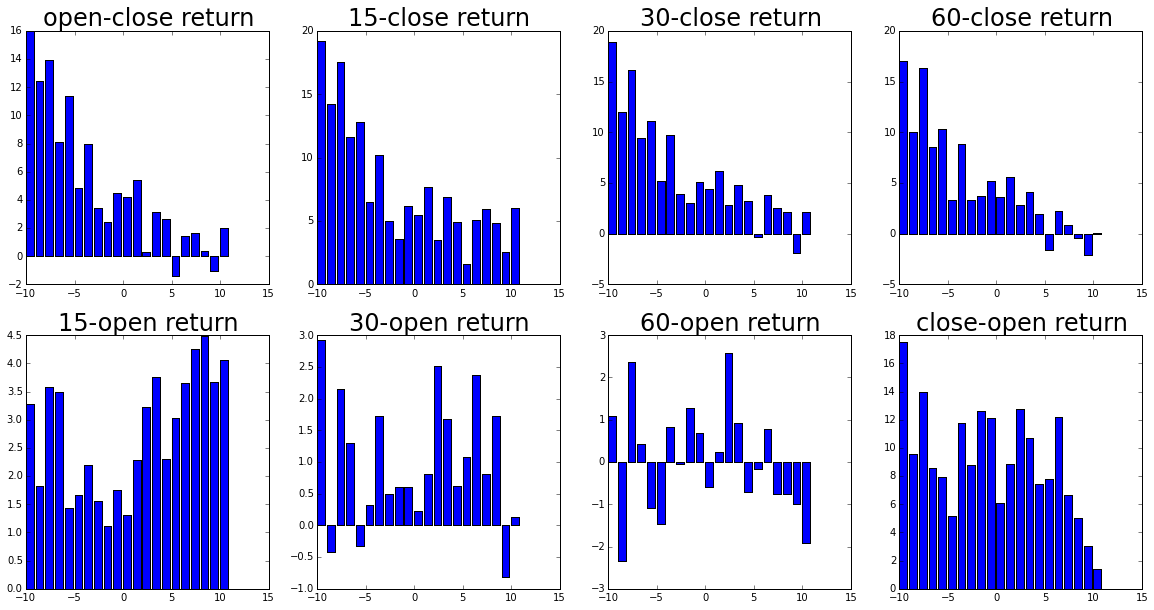

In [116]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20,10))
l1=ax1.bar(np.arange(-10, 11), ret0)
ax1.set_title(r'open-close return', fontsize=24)
l2 = ax2.bar(np.arange(-10, 11), ret15)
ax2.set_title(r'15-close return', fontsize=24)

l3 = ax3.bar(np.arange(-10, 11), ret30)
ax3.set_title(r'30-close return', fontsize=24)

l4=ax4.bar(np.arange(-10, 11), ret60)
ax4.set_title(r'60-close return', fontsize=24)

l5 = ax5.bar(np.arange(-10, 11), ret15_open)
ax5.set_title(r'15-open return', fontsize=24)

l6 = ax6.bar(np.arange(-10, 11), ret30_open)
ax6.set_title(r'30-open return', fontsize=24)

l7 = ax7.bar(np.arange(-10, 11), ret60_open)
ax7.set_title(r'60-open return', fontsize=24)

l8 = ax8.bar(np.arange(-10, 11), retclose_open)
ax8.set_title(r'close-open return', fontsize=24)

## Last 15min log return

In [152]:
import statsmodels.api as sm

for stock in newstocks:
    result.get(stock)['signal_line30'] = np.zeros(days.size-1)

for stock in newstocks:
    logret=np.zeros(days.size); i=0
    daysdf = data_train.get(stock).groupby('date')
    for dt, df in daysdf:
        y=df.mid.values
        x=np.arange(y.size)+1
        x=sm.add_constant(x)
        logret[i] = sm.OLS(y,x).fit().params[1]
        i+=1
    result.get(stock)['signal_line30'] = logret[0:-1]

In [153]:
result['A'].head(2)

,day,signal,close,open,price15,return0,return15,price30,price60,new_close,return30,return60,return_close,return15_open,return30_open,return60_open,returnclose_open,signal_30ret,signal_15ret,signal_line30
1,2013-01-03,-5.863329,41.880001,41.725,41.745,-0.003708,-0.003229,41.685,41.655,42.025,-0.004667,-0.005387,0.003456,0.000479,-0.000959,-0.001679,0.007164,0.008153,0.003365,0.012754
2,2013-01-04,-6.552647,42.029999,41.905,42.025,-0.002978,-0.000119,42.255,42.305,42.855,0.005339,0.006522,0.019439,0.002860,0.008318,0.009500,0.022417,0.003815,0.002624,0.003748


In [155]:
all_sigs=pd.concat([result.get(stock).signal_line30 for stock in newstocks])
perc = [0.5, 40, 50, 60, 99.5]
for p in perc:
    print np.percentile(all_sigs, p) 

-0.0252754032258
-0.000604838709678
-6.04838709681e-06
0.000588709677419
0.0237161794355


In [156]:
print all_sigs.min(), all_sigs.max()

-40.1771451613 19.4148104839


In [157]:
toplot = {stock: pd.DataFrame for stock in newstocks}
for stock in newstocks:
    thisdf = result[stock]
    toplot[stock] = thisdf.loc[(thisdf.return0<0.18)&(thisdf.return0>-0.21)\
                              &(thisdf.signal_line30>-0.0253)&(thisdf.signal_line30<0.0238)\
                              &(thisdf.signal_15ret.abs()>2e-4)]

In [158]:
all_sigs=pd.concat([toplot.get(stock).signal_line30 for stock in newstocks])
Alphabins=[all_sigs.quantile(i/22.0) for i in range(22)]
Alphabins[0]-=0.001; Alphabins[-1]+=0.001

In [159]:
for stock in newstocks:
    toplot.get(stock)['signalbin']=pd.cut(toplot[stock].signal_line30, Alphabins, labels=range(-10,11))

/Users/cong/.pyenv/versions/anaconda-2.3.0/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [160]:
size_a = np.zeros(21);
ret_mean0 = np.zeros(21); ret_mean15 = np.zeros(21); ret_mean30 = np.zeros(21); ret_mean60 = np.zeros(21)
ret_mean15_open = np.zeros(21); ret_mean30_open = np.zeros(21); ret_mean60_open = np.zeros(21); ret_meanclose_open = np.zeros(21)
for stock in newstocks:
    size_a += toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean0 += toplot[stock].groupby('signalbin')['return0'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15 += toplot[stock].groupby('signalbin')['return15'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30 += toplot[stock].groupby('signalbin')['return30'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60 += toplot[stock].groupby('signalbin')['return60'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15_open += toplot[stock].groupby('signalbin')['return15_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30_open += toplot[stock].groupby('signalbin')['return30_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60_open += toplot[stock].groupby('signalbin')['return60_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_meanclose_open += toplot[stock].groupby('signalbin')['returnclose_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)

ret0 = ret_mean0/size_a*10000
ret15 = ret_mean15/size_a*10000
ret30 = ret_mean30/size_a*10000
ret60 = ret_mean60/size_a*10000
ret15_open = ret_mean15_open/size_a*10000
ret30_open = ret_mean30_open/size_a*10000
ret60_open = ret_mean60_open/size_a*10000
retclose_open = ret_meanclose_open/size_a*10000

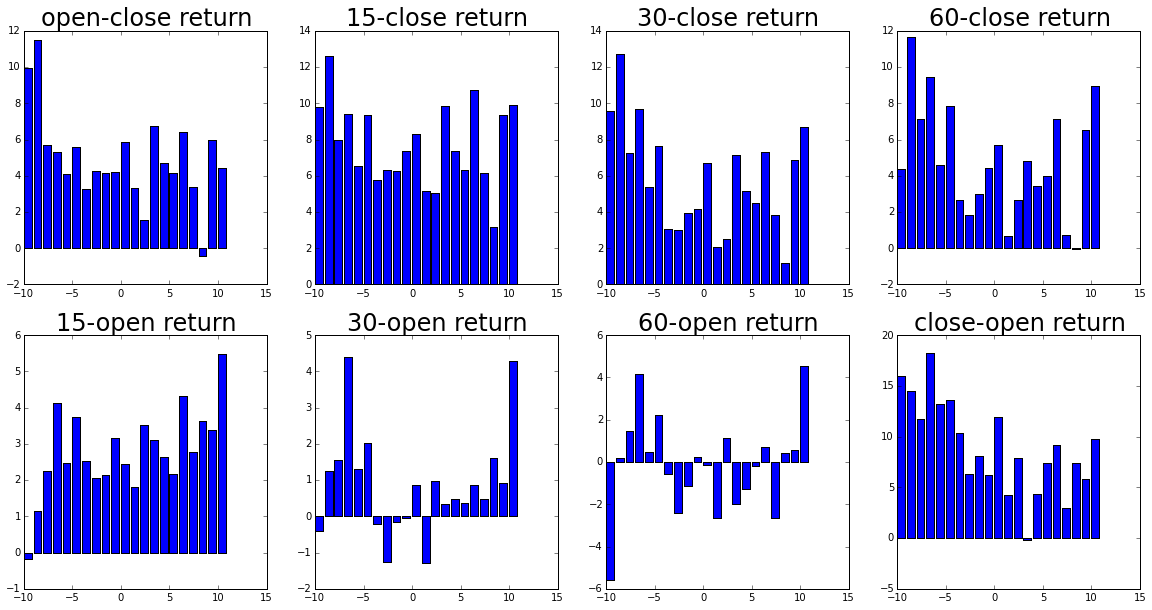

In [161]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20,10))
l1=ax1.bar(np.arange(-10, 11), ret0)
ax1.set_title(r'open-close return', fontsize=24)
l2 = ax2.bar(np.arange(-10, 11), ret15)
ax2.set_title(r'15-close return', fontsize=24)

l3 = ax3.bar(np.arange(-10, 11), ret30)
ax3.set_title(r'30-close return', fontsize=24)

l4=ax4.bar(np.arange(-10, 11), ret60)
ax4.set_title(r'60-close return', fontsize=24)

l5 = ax5.bar(np.arange(-10, 11), ret15_open)
ax5.set_title(r'15-open return', fontsize=24)

l6 = ax6.bar(np.arange(-10, 11), ret30_open)
ax6.set_title(r'30-open return', fontsize=24)

l7 = ax7.bar(np.arange(-10, 11), ret60_open)
ax7.set_title(r'60-open return', fontsize=24)

l8 = ax8.bar(np.arange(-10, 11), retclose_open)
ax8.set_title(r'close-open return', fontsize=24)

## Last 30min price slope

In [162]:
for stock in newstocks:
    result.get(stock)['signal_line15'] = np.zeros(days.size-1)

for stock in newstocks:
    logret=np.zeros(days.size); i=0
    daysdf = data_train.get(stock).groupby('date')
    for dt, df in daysdf:
        y=df.mid.values[:15]
        x=np.arange(y.size)
        x=sm.add_constant(x)+1
        logret[i] = sm.OLS(y,x).fit().params[1]
        i+=1
    result.get(stock)['signal_line15'] = logret[0:-1]

In [163]:
all_sigs=pd.concat([result.get(stock).signal_line15 for stock in newstocks])
perc = [0.5, 40, 50, 60, 99.5]
for p in perc:
    print np.percentile(all_sigs, p) 
print all_sigs.min(), all_sigs.max()

-0.0341839285714
-0.000660714285714
3.5714285714e-05
0.000892857142858
0.0354397321429
-40.77625 190.525607143


In [164]:
toplot = {stock: pd.DataFrame for stock in newstocks}
for stock in newstocks:
    thisdf = result[stock]
    toplot[stock] = thisdf.loc[(thisdf.return0<0.18)&(thisdf.return0>-0.21)\
                              &(thisdf.signal_line15>-0.0342)&(thisdf.signal_line15<0.0355)\
                              &(thisdf.signal_line15.abs()>2e-4)]

In [165]:
all_sigs=pd.concat([toplot.get(stock).signal_line15 for stock in newstocks])
Alphabins=[all_sigs.quantile(i/22.0) for i in range(22)]
Alphabins[0]-=0.001; Alphabins[-1]+=0.001

In [166]:
for stock in newstocks:
    toplot.get(stock)['signalbin']=pd.cut(toplot[stock].signal_line15, Alphabins, labels=range(-10,11))

/Users/cong/.pyenv/versions/anaconda-2.3.0/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [167]:
size_a = np.zeros(21);
ret_mean0 = np.zeros(21); ret_mean15 = np.zeros(21); ret_mean30 = np.zeros(21); ret_mean60 = np.zeros(21)
ret_mean15_open = np.zeros(21); ret_mean30_open = np.zeros(21); ret_mean60_open = np.zeros(21); ret_meanclose_open = np.zeros(21)
for stock in newstocks:
    size_a += toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean0 += toplot[stock].groupby('signalbin')['return0'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15 += toplot[stock].groupby('signalbin')['return15'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30 += toplot[stock].groupby('signalbin')['return30'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60 += toplot[stock].groupby('signalbin')['return60'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15_open += toplot[stock].groupby('signalbin')['return15_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30_open += toplot[stock].groupby('signalbin')['return30_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60_open += toplot[stock].groupby('signalbin')['return60_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_meanclose_open += toplot[stock].groupby('signalbin')['returnclose_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)

ret0 = ret_mean0/size_a*10000
ret15 = ret_mean15/size_a*10000
ret30 = ret_mean30/size_a*10000
ret60 = ret_mean60/size_a*10000
ret15_open = ret_mean15_open/size_a*10000
ret30_open = ret_mean30_open/size_a*10000
ret60_open = ret_mean60_open/size_a*10000
retclose_open = ret_meanclose_open/size_a*10000

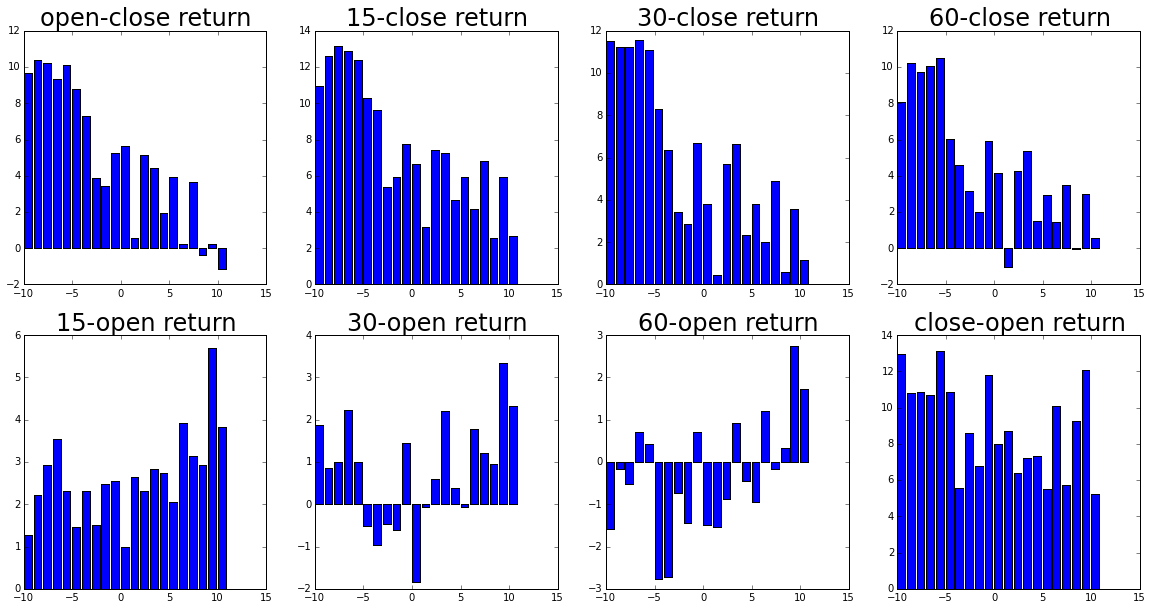

In [168]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20,10))
l1=ax1.bar(np.arange(-10, 11), ret0)
ax1.set_title(r'open-close return', fontsize=24)
l2 = ax2.bar(np.arange(-10, 11), ret15)
ax2.set_title(r'15-close return', fontsize=24)

l3 = ax3.bar(np.arange(-10, 11), ret30)
ax3.set_title(r'30-close return', fontsize=24)

l4=ax4.bar(np.arange(-10, 11), ret60)
ax4.set_title(r'60-close return', fontsize=24)

l5 = ax5.bar(np.arange(-10, 11), ret15_open)
ax5.set_title(r'15-open return', fontsize=24)

l6 = ax6.bar(np.arange(-10, 11), ret30_open)
ax6.set_title(r'30-open return', fontsize=24)

l7 = ax7.bar(np.arange(-10, 11), ret60_open)
ax7.set_title(r'60-open return', fontsize=24)

l8 = ax8.bar(np.arange(-10, 11), retclose_open)
ax8.set_title(r'close-open return', fontsize=24)

## 15 minutes price slope

In [171]:
for stock in newstocks:
    result.get(stock)['signal_line_diff'] = np.zeros(days.size-1)
    result.get(stock)['signal_line_diff'] = (result.get(stock)['signal_line15']-result.get(stock)['signal_line30'])*100

In [172]:
all_sigs=pd.concat([result.get(stock).signal_line_diff for stock in newstocks])
perc = [0.5, 40, 50, 60, 99.5]
for p in perc:
    print np.percentile(all_sigs, p) 
print all_sigs.min(), all_sigs.max()

-2.68925835253
-0.0581797235023
0.0133352534563
0.0905241935484
3.15926123272
-2783.55599078 19748.9713998


In [173]:
toplot = {stock: pd.DataFrame for stock in newstocks}
for stock in newstocks:
    thisdf = result[stock]
    toplot[stock] = thisdf.loc[(thisdf.return0<0.18)&(thisdf.return0>-0.21)\
                              &(thisdf.signal_line_diff>-2.69)&(thisdf.signal_line_diff<3.16)]

In [174]:
all_sigs=pd.concat([toplot.get(stock).signal_line_diff for stock in newstocks])
Alphabins=[all_sigs.quantile(i/22.0) for i in range(22)]
Alphabins[0]-=0.001; Alphabins[-1]+=0.001

In [175]:
for stock in newstocks:
    toplot.get(stock)['signalbin']=pd.cut(toplot[stock].signal_line_diff, Alphabins, labels=range(-10,11))

/Users/cong/.pyenv/versions/anaconda-2.3.0/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [176]:
size_a = np.zeros(21);
ret_mean0 = np.zeros(21); ret_mean15 = np.zeros(21); ret_mean30 = np.zeros(21); ret_mean60 = np.zeros(21)
ret_mean15_open = np.zeros(21); ret_mean30_open = np.zeros(21); ret_mean60_open = np.zeros(21); ret_meanclose_open = np.zeros(21)
for stock in newstocks:
    size_a += toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean0 += toplot[stock].groupby('signalbin')['return0'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15 += toplot[stock].groupby('signalbin')['return15'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30 += toplot[stock].groupby('signalbin')['return30'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60 += toplot[stock].groupby('signalbin')['return60'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15_open += toplot[stock].groupby('signalbin')['return15_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30_open += toplot[stock].groupby('signalbin')['return30_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60_open += toplot[stock].groupby('signalbin')['return60_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_meanclose_open += toplot[stock].groupby('signalbin')['returnclose_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)

ret0 = ret_mean0/size_a*10000
ret15 = ret_mean15/size_a*10000
ret30 = ret_mean30/size_a*10000
ret60 = ret_mean60/size_a*10000
ret15_open = ret_mean15_open/size_a*10000
ret30_open = ret_mean30_open/size_a*10000
ret60_open = ret_mean60_open/size_a*10000
retclose_open = ret_meanclose_open/size_a*10000

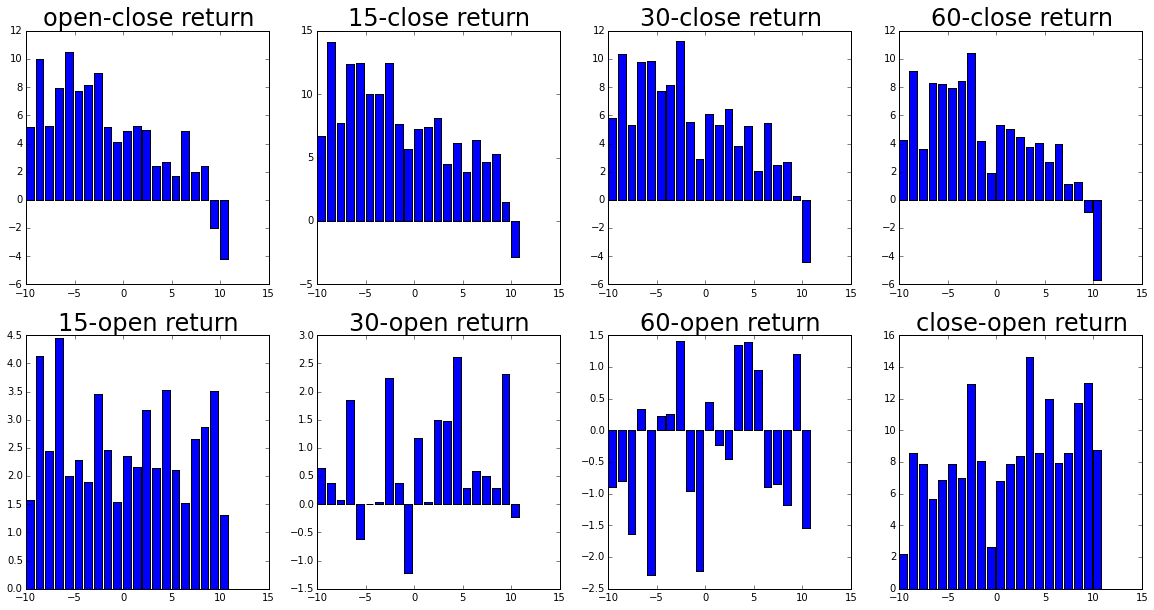

In [177]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20,10))
l1=ax1.bar(np.arange(-10, 11), ret0)
ax1.set_title(r'open-close return', fontsize=24)
l2 = ax2.bar(np.arange(-10, 11), ret15)
ax2.set_title(r'15-close return', fontsize=24)

l3 = ax3.bar(np.arange(-10, 11), ret30)
ax3.set_title(r'30-close return', fontsize=24)

l4=ax4.bar(np.arange(-10, 11), ret60)
ax4.set_title(r'60-close return', fontsize=24)

l5 = ax5.bar(np.arange(-10, 11), ret15_open)
ax5.set_title(r'15-open return', fontsize=24)

l6 = ax6.bar(np.arange(-10, 11), ret30_open)
ax6.set_title(r'30-open return', fontsize=24)

l7 = ax7.bar(np.arange(-10, 11), ret60_open)
ax7.set_title(r'60-open return', fontsize=24)

l8 = ax8.bar(np.arange(-10, 11), retclose_open)
ax8.set_title(r'close-open return', fontsize=24)

## Last 15min slope minus previous 15min slope

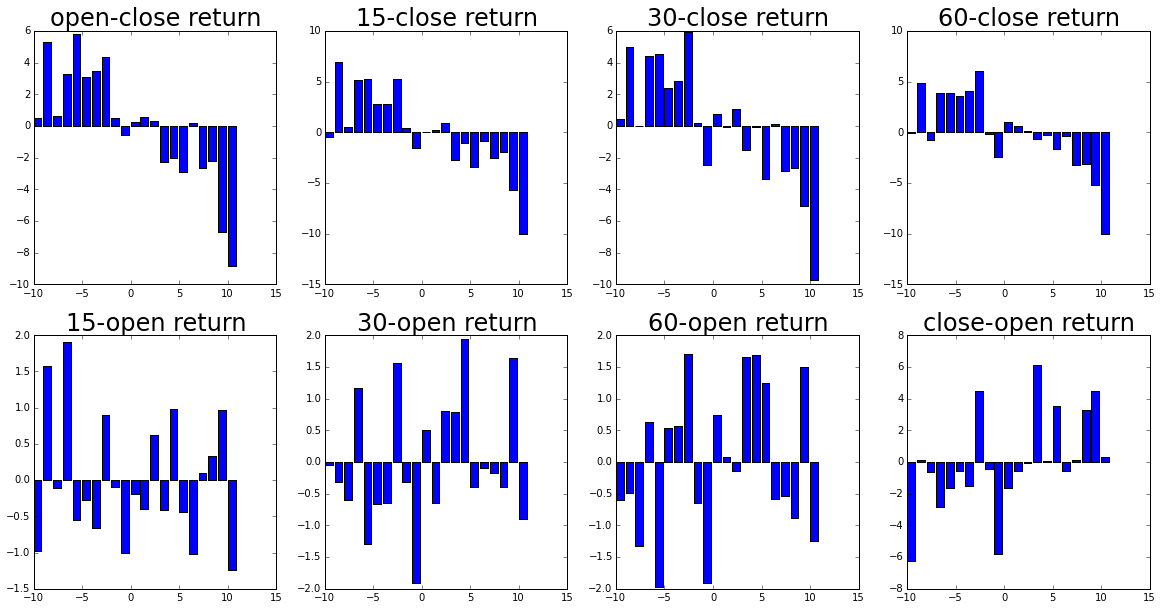

In [186]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20,10))
l1 = ax1.bar(np.arange(-10, 11), ret0-ret0.mean())
ax1.set_title(r'open-close return', fontsize=24)

l2 = ax2.bar(np.arange(-10, 11), ret15-ret15.mean() )
ax2.set_title(r'15-close return', fontsize=24)

l3 = ax3.bar(np.arange(-10, 11), ret30-ret30.mean())
ax3.set_title(r'30-close return', fontsize=24)

l4=ax4.bar(np.arange(-10, 11), ret60-ret60.mean())
ax4.set_title(r'60-close return', fontsize=24)

l5 = ax5.bar(np.arange(-10, 11), ret15_open-ret15_open.mean())
ax5.set_title(r'15-open return', fontsize=24)

l6 = ax6.bar(np.arange(-10, 11), ret30_open-ret30_open.mean())
ax6.set_title(r'30-open return', fontsize=24)

l7 = ax7.bar(np.arange(-10, 11), ret60_open-ret60_open.mean())
ax7.set_title(r'60-open return', fontsize=24)

l8 = ax8.bar(np.arange(-10, 11), retclose_open-retclose_open.mean())
ax8.set_title(r'close-open return', fontsize=24)

In [191]:
for stock in newstocks:
    result.get(stock)['signal_bs'] = np.zeros(days.size-1)

for stock in newstocks:
    logret=np.zeros(days.size); i=0
    daysdf = data_train.get(stock).groupby('date')
    for dt, df in daysdf:
        y=df.logmid.diff(-1)[:-1]
        x=np.arange(y.size)+1
        x=sm.add_constant(x)
        logret[i]=sm.OLS(y, x).fit().params[1]
        i+=1
    result.get(stock)['signal_bs'] = logret[0:-1]

In [194]:
for stock in newstocks:
    result.get(stock)['signal_bs']*=1e5
    
all_sigs=pd.concat([result.get(stock).signal_bs for stock in newstocks])
perc = [0.5, 40, 50, 60, 99.5]
for p in perc:
    print np.percentile(all_sigs, p) 
print all_sigs.min(), all_sigs.max()

-4.88906942142
-0.346116586831
-0.0989963395434
0.140942976517
4.47413869276
-23.0976653333 59.2574717144


In [193]:
result['A']

,day,signal,close,open,price15,return0,return15,price30,price60,new_close,...,return15_open,return30_open,return60_open,returnclose_open,signal_30ret,signal_15ret,signal_line30,signal_line15,signal_line_diff,signal_bs
1,2013-01-03,-5.863329,41.880001,41.725,41.745,-0.003708,-0.003229,41.685,41.655,42.025,...,0.000479,-0.000959,-0.001679,0.007164,0.008153,0.003365,0.012754,1.025000e-02,-0.250403,-1.029182e-05
2,2013-01-04,-6.552647,42.029999,41.905,42.025,-0.002978,-0.000119,42.255,42.305,42.855,...,0.002860,0.008318,0.009500,0.022417,0.003815,0.002624,0.003748,1.058929e-02,0.684130,-5.664766e-06
3,2013-01-07,-7.505401,42.860001,42.595,42.785,-0.006202,-0.001751,42.575,42.535,42.560,...,0.004451,-0.000470,-0.001410,-0.000822,-0.001632,0.000000,-0.000665,1.285714e-03,0.195104,1.869757e-06
4,2013-01-08,-7.159649,42.549999,42.785,42.680,0.005508,0.003051,42.655,42.490,42.220,...,-0.002457,-0.003043,-0.006919,-0.013294,-0.001761,-0.000939,-0.003208,-5.000000e-03,-0.179234,1.228568e-06
5,2013-01-09,-6.640947,42.209999,42.695,43.165,0.011425,0.022373,43.385,43.185,43.335,...,0.010948,0.016032,0.011411,0.014879,-0.002720,-0.002365,-0.004867,-8.839286e-03,-0.397235,-3.445740e-06
6,2013-01-10,-7.239555,43.349998,43.735,43.925,0.008842,0.013177,43.835,43.745,43.670,...,0.004335,0.002284,0.000229,-0.001487,0.001154,-0.000925,0.002202,-3.357143e-03,-0.555876,-7.554120e-06
7,2013-01-11,-7.413560,43.669998,43.665,43.545,-0.000114,-0.002866,43.725,43.785,43.445,...,-0.002752,0.001373,0.002744,-0.005051,0.001031,-0.001376,-0.000143,-5.535714e-03,-0.539257,-1.195814e-05
8,2013-01-14,-7.459136,43.430000,43.210,43.045,-0.005079,-0.008904,43.025,42.995,43.535,...,-0.003826,-0.004291,-0.004988,0.007493,-0.001380,-0.000460,-0.002310,-2.321429e-03,-0.001094,-1.738883e-06
9,2013-01-15,-7.317064,43.540001,43.205,43.310,-0.007724,-0.005297,43.235,43.185,43.235,...,0.002427,0.000694,-0.000463,0.000694,0.002530,0.001611,0.001302,6.642857e-03,0.534044,-5.570121e-06
10,2013-01-16,-6.692955,43.240002,42.965,42.935,-0.006380,-0.007079,43.005,43.065,43.040,...,-0.000698,0.000931,0.002325,0.001744,0.003243,0.002434,0.005617,4.928571e-03,-0.068836,2.120832e-06


In [195]:
toplot = {stock: pd.DataFrame for stock in newstocks}
for stock in newstocks:
    thisdf = result[stock]
    toplot[stock] = thisdf.loc[(thisdf.return0<0.18)&(thisdf.return0>-0.21)\
                              &(thisdf.signal_bs>-4.89)&(thisdf.signal_bs<4.475)]

In [196]:
all_sigs=pd.concat([toplot.get(stock).signal_bs for stock in newstocks])
Alphabins=[all_sigs.quantile(i/22.0) for i in range(22)]
Alphabins[0]-=0.001; Alphabins[-1]+=0.001

In [207]:
for stock in newstocks:
    toplot.get(stock)['signalbin']=pd.cut(toplot[stock].signal_bs, Alphabins, labels=range(-10,11))

/Users/cong/.pyenv/versions/anaconda-2.3.0/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [208]:
size_a = np.zeros(21);
ret_mean0 = np.zeros(21); ret_mean15 = np.zeros(21); ret_mean30 = np.zeros(21); ret_mean60 = np.zeros(21)
ret_mean15_open = np.zeros(21); ret_mean30_open = np.zeros(21); ret_mean60_open = np.zeros(21); ret_meanclose_open = np.zeros(21)
for stock in newstocks:
    size_a += toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean0 += toplot[stock].groupby('signalbin')['return0'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15 += toplot[stock].groupby('signalbin')['return15'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30 += toplot[stock].groupby('signalbin')['return30'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60 += toplot[stock].groupby('signalbin')['return60'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15_open += toplot[stock].groupby('signalbin')['return15_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30_open += toplot[stock].groupby('signalbin')['return30_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60_open += toplot[stock].groupby('signalbin')['return60_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_meanclose_open += toplot[stock].groupby('signalbin')['returnclose_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)

ret0 = ret_mean0/size_a*10000
ret15 = ret_mean15/size_a*10000
ret30 = ret_mean30/size_a*10000
ret60 = ret_mean60/size_a*10000
ret15_open = ret_mean15_open/size_a*10000
ret30_open = ret_mean30_open/size_a*10000
ret60_open = ret_mean60_open/size_a*10000
retclose_open = ret_meanclose_open/size_a*10000

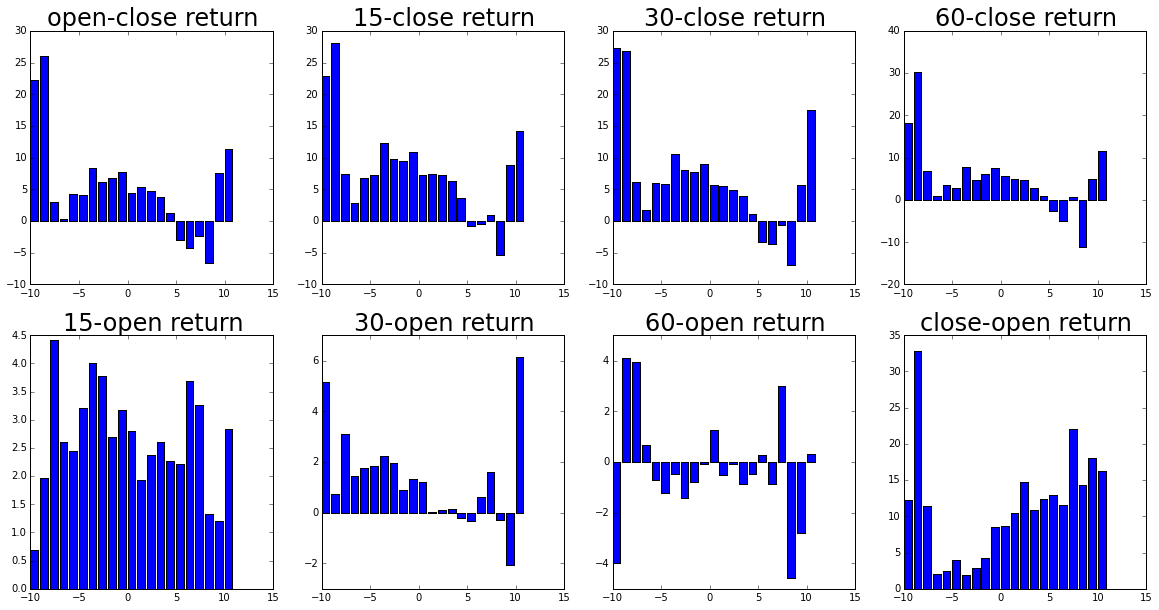

In [209]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20,10))
l1=ax1.bar(np.arange(-10, 11), ret0)
ax1.set_title(r'open-close return', fontsize=24)
l2 = ax2.bar(np.arange(-10, 11), ret15)
ax2.set_title(r'15-close return', fontsize=24)

l3 = ax3.bar(np.arange(-10, 11), ret30)
ax3.set_title(r'30-close return', fontsize=24)

l4=ax4.bar(np.arange(-10, 11), ret60)
ax4.set_title(r'60-close return', fontsize=24)

l5 = ax5.bar(np.arange(-10, 11), ret15_open)
ax5.set_title(r'15-open return', fontsize=24)

l6 = ax6.bar(np.arange(-10, 11), ret30_open)
ax6.set_title(r'30-open return', fontsize=24)

l7 = ax7.bar(np.arange(-10, 11), ret60_open)
ax7.set_title(r'60-open return', fontsize=24)

l8 = ax8.bar(np.arange(-10, 11), retclose_open)
ax8.set_title(r'close-open return', fontsize=24)

## Last 30min log return slope

In [211]:
for stock in newstocks:
    result.get(stock)['signal_bs15'] = np.zeros(days.size-1)

for stock in newstocks:
    logret=np.zeros(days.size); i=0
    daysdf = data_train.get(stock).groupby('date')
    for dt, df in daysdf:
        y=(df.mid.diff(-1)/df.mid)[-15:-1]
        x=np.arange(y.size)+1
        x=sm.add_constant(x)
        logret[i]=sm.OLS(y, x).fit().params[1]
        i+=1
    result.get(stock)['signal_bs15'] = logret[0:-1]

In [214]:
for stock in newstocks:
    result.get(stock)['signal_bs15']*=1e5
    
all_sigs=pd.concat([result.get(stock).signal_bs15 for stock in newstocks])
perc = [0.5, 20, 40, 50, 60, 80, 99.5]
for p in perc:
    print np.percentile(all_sigs, p)
print all_sigs.min(), all_sigs.max()

-16.9860296667
-3.76465792865
-1.66055093006
-0.855701286643
-0.0586862142695
1.86976069078
14.3937782425
-231.581232004 165.567582914


In [215]:
toplot = {stock: pd.DataFrame for stock in newstocks}
for stock in newstocks:
    thisdf = result[stock]
    toplot[stock] = thisdf.loc[(thisdf.return0<0.18)&(thisdf.return0>-0.21)\
                              &(thisdf.signal_bs15>-16.99)&(thisdf.signal_bs15<14.4)\
                              &(thisdf.signal_bs15.abs()>0.1)]

In [216]:
all_sigs=pd.concat([toplot.get(stock).signal_bs15 for stock in newstocks])
Alphabins=[all_sigs.quantile(i/22.0) for i in range(22)]
Alphabins[0]-=0.01; Alphabins[-1]+=0.01

In [217]:
for stock in newstocks:
    toplot.get(stock)['signalbin']=pd.cut(toplot[stock].signal_bs15, Alphabins, labels=range(-10,11))

/Users/cong/.pyenv/versions/anaconda-2.3.0/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [218]:
size_a = np.zeros(21);
ret_mean0 = np.zeros(21); ret_mean15 = np.zeros(21); ret_mean30 = np.zeros(21); ret_mean60 = np.zeros(21)
ret_mean15_open = np.zeros(21); ret_mean30_open = np.zeros(21); ret_mean60_open = np.zeros(21); ret_meanclose_open = np.zeros(21)
for stock in newstocks:
    size_a += toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean0 += toplot[stock].groupby('signalbin')['return0'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15 += toplot[stock].groupby('signalbin')['return15'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30 += toplot[stock].groupby('signalbin')['return30'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60 += toplot[stock].groupby('signalbin')['return60'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean15_open += toplot[stock].groupby('signalbin')['return15_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean30_open += toplot[stock].groupby('signalbin')['return30_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_mean60_open += toplot[stock].groupby('signalbin')['return60_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)
    ret_meanclose_open += toplot[stock].groupby('signalbin')['returnclose_open'].mean().fillna(0)*\
                 toplot[stock].groupby('signalbin').size().fillna(0)

ret0 = ret_mean0/size_a*10000
ret15 = ret_mean15/size_a*10000
ret30 = ret_mean30/size_a*10000
ret60 = ret_mean60/size_a*10000
ret15_open = ret_mean15_open/size_a*10000
ret30_open = ret_mean30_open/size_a*10000
ret60_open = ret_mean60_open/size_a*10000
retclose_open = ret_meanclose_open/size_a*10000

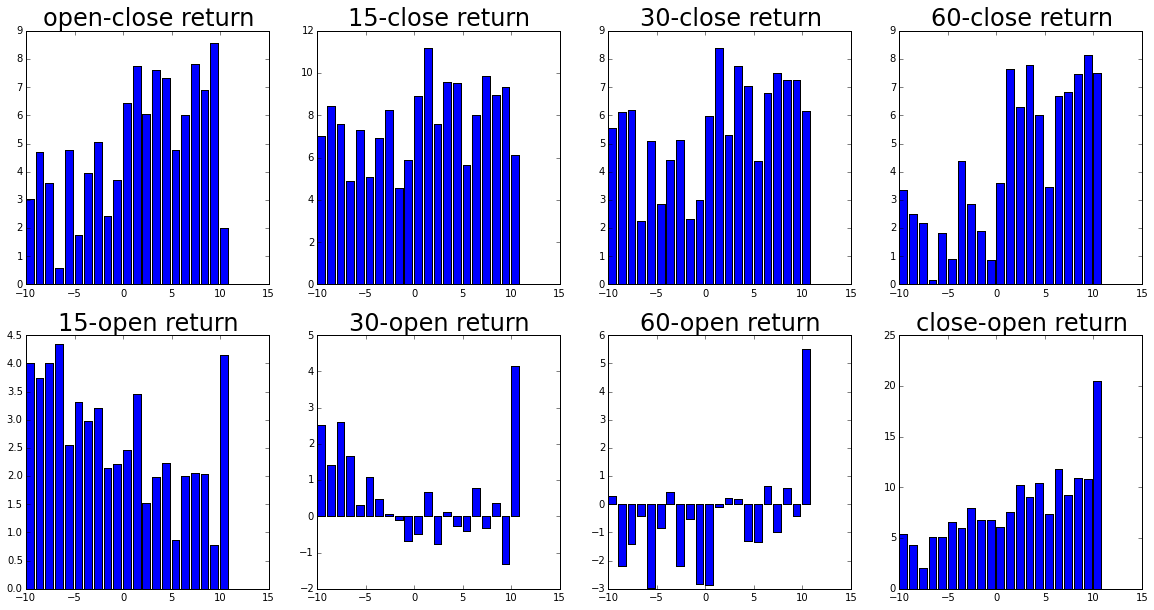

In [220]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20,10))
l1=ax1.bar(np.arange(-10, 11), ret0)
ax1.set_title(r'open-close return', fontsize=24)
l2 = ax2.bar(np.arange(-10, 11), ret15)
ax2.set_title(r'15-close return', fontsize=24)

l3 = ax3.bar(np.arange(-10, 11), ret30)
ax3.set_title(r'30-close return', fontsize=24)

l4=ax4.bar(np.arange(-10, 11), ret60)
ax4.set_title(r'60-close return', fontsize=24)

l5 = ax5.bar(np.arange(-10, 11), ret15_open)
ax5.set_title(r'15-open return', fontsize=24)

l6 = ax6.bar(np.arange(-10, 11), ret30_open)
ax6.set_title(r'30-open return', fontsize=24)

l7 = ax7.bar(np.arange(-10, 11), ret60_open)
ax7.set_title(r'60-open return', fontsize=24)

l8 = ax8.bar(np.arange(-10, 11), retclose_open)
ax8.set_title(r'close-open return', fontsize=24)

## Last 15min log return slope

In [221]:
thisdf = result.get('A')
thisdf.head(2)

,day,signal,close,open,price15,return0,return15,price30,price60,new_close,...,return30_open,return60_open,returnclose_open,signal_30ret,signal_15ret,signal_line30,signal_line15,signal_line_diff,signal_bs,signal_bs15
1,2013-01-03,-5.863329,41.880001,41.725,41.745,-0.003708,-0.003229,41.685,41.655,42.025,...,-0.000959,-0.001679,0.007164,0.008153,0.003365,0.012754,0.010250,-0.250403,-1.029182,0.223850
2,2013-01-04,-6.552647,42.029999,41.905,42.025,-0.002978,-0.000119,42.255,42.305,42.855,...,0.008318,0.009500,0.022417,0.003815,0.002624,0.003748,0.010589,0.684130,-0.566477,-8.330869


In [262]:
toplot = {stock: pd.DataFrame for stock in newstocks}
for stock in newstocks:
    thisdf = result[stock]
    toplot[stock] = thisdf.loc[(thisdf.return0<0.18)&(thisdf.return0>-0.21)\
                              &(thisdf.signal_15ret>-0.0078)&(thisdf.signal_15ret<0.0076)\
                              &(thisdf.signal_15ret.abs()>0.0001)\
                              &(thisdf.signal_line_diff>-2.69)&(thisdf.signal_line_diff<3.16)\
                              &(thisdf.signal<-4)&(thisdf.signal>-10)
                              ]

In [279]:
x = pd.concat([thisdf.loc[:,['signal_15ret', 'signal', 'signal_line_diff']] for thisdf in toplot.values() ])
x = sm.add_constant(x)
y = pd.concat([thisdf.return15 for thisdf in toplot.values()])
model = sm.OLS(y.values, x.values).fit()

In [273]:
for stock in newstocks:
    thisdf = toplot.get(stock)
    x = thisdf.loc[:,['signal_15ret', 'signal', 'signal_line_diff']]
    x = sm.add_constant(x)
    y = model.predict(x)
    toplot.get(stock)['signal_combine1'] = y

/Users/cong/.pyenv/versions/anaconda-2.3.0/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [274]:
all_sigs=pd.concat([toplot.get(stock).signal_combine1 for stock in newstocks])
Alphabins=[all_sigs.quantile(i/22.0) for i in range(22)]
Alphabins[0]-=0.01; Alphabins[-1]+=0.01

In [280]:
model.params

array([  3.12796226e-03,  -1.46895086e-01,   3.34865963e-04,
        -1.07650405e-04])

In [284]:
x = pd.concat([thisdf.loc[:,['signal_15ret', 'signal', 'signal_line_diff']] for thisdf in toplot.values() ])
x = sm.add_constant(x)
y = pd.concat([thisdf.return15 for thisdf in toplot.values()])
x['signal_15ret']*=1e4
x['signal_line_diff'] *=10
y *= 1e4
model = sm.OLS(y.values, x.values).fit()

In [285]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     22.94
Date:                Wed, 30 Dec 2015   Prob (F-statistic):           7.82e-15
Time:                        12:37:27   Log-Likelihood:            -4.1963e+05
No. Observations:               67735   AIC:                         8.393e+05
Df Residuals:                   67731   BIC:                         8.393e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         31.2796      5.535      5.651      0.000        20.431    42.128
x1            -0.1469      0.026     -5.739      0.000        -0.197    -0.097
x2             3.3487      0.786      4.262      0.000         1.809     4.889
x3            -0.1077      0.090     -1.200      0.230        -0.284     0.068
==============================================================================
Omnibus:                    23605.236   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4290766.059
Skew:                          -0.525   Prob(JB):                         0.00
Kurtosis:                      41.977   Cond. No.                         245.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [288]:
signal_combine = model.predict(x)
ret = pd.concat([thisdf.loc[:,['return0', 'return15', 'return30',\
                           'return60', 'return15_open', 'return30_open',\
                           'return60_open', 'returnclose_open']]\
                 for thisdf in toplot.values()])

In [293]:
Alphabins=[np.percentile(signal_combine, (i/22.0*100)) for i in range(22)]
Alphabins[0]-=0.01; Alphabins[-1]+=0.01

In [295]:
ret['signal_bins'] = pd.cut(signal_combine, Alphabins, labels=range(-10,11))

In [299]:
ret_mean = ret.groupby('signal_bins').mean()

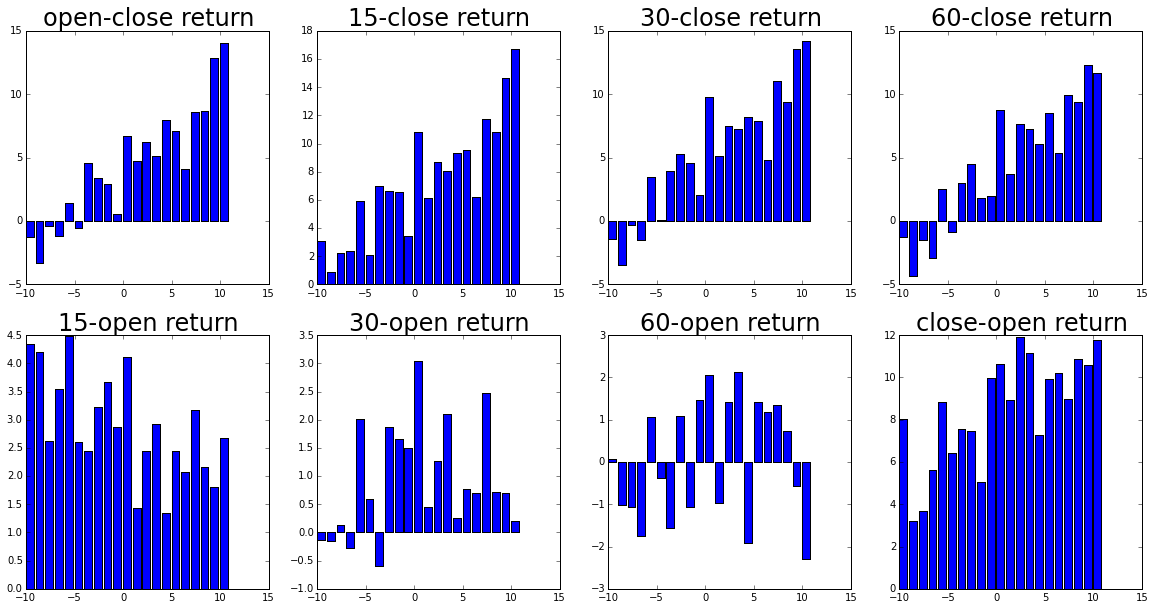

In [303]:
ret_mean*=1e4

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(20,10))
l1=ax1.bar(np.arange(-10, 11), ret_mean['return0'])
ax1.set_title(r'open-close return', fontsize=24)
l2 = ax2.bar(np.arange(-10, 11), ret_mean['return15'])
ax2.set_title(r'15-close return', fontsize=24)

l3 = ax3.bar(np.arange(-10, 11), ret_mean['return30'])
ax3.set_title(r'30-close return', fontsize=24)

l4=ax4.bar(np.arange(-10, 11), ret_mean['return60'])
ax4.set_title(r'60-close return', fontsize=24)

l5 = ax5.bar(np.arange(-10, 11), ret_mean['return15_open'])
ax5.set_title(r'15-open return', fontsize=24)

l6 = ax6.bar(np.arange(-10, 11), ret_mean['return30_open'])
ax6.set_title(r'30-open return', fontsize=24)

l7 = ax7.bar(np.arange(-10, 11), ret_mean['return60_open'])
ax7.set_title(r'60-open return', fontsize=24)

l8 = ax8.bar(np.arange(-10, 11), ret_mean['returnclose_open'])
ax8.set_title(r'close-open return', fontsize=24)

In [301]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     22.94
Date:                Wed, 30 Dec 2015   Prob (F-statistic):           7.82e-15
Time:                        12:50:57   Log-Likelihood:            -4.1963e+05
No. Observations:               67735   AIC:                         8.393e+05
Df Residuals:                   67731   BIC:                         8.393e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         31.2796      5.535      5.651      0.000        20.431    42.128
x1            -0.1469      0.026     -5.739      0.000        -0.197    -0.097
x2             3.3487      0.786      4.262      0.000         1.809     4.889
x3            -0.1077      0.090     -1.200      0.230        -0.284     0.068
==============================================================================
Omnibus:                    23605.236   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4290766.059
Skew:                          -0.525   Prob(JB):                         0.00
Kurtosis:                      41.977   Cond. No.                         245.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [302]:
ret_mean

,return0,return15,return30,return60,return15_open,return30_open,return60_open,returnclose_open
signal_bins,,,,,,,,
-10,-0.000128,0.000305,-0.000143,-0.000122,0.000434,-0.000014,0.000006,0.000803
-9,-0.000334,0.000086,-0.000348,-0.000436,0.000420,-0.000014,-0.000102,0.000321
-8,-0.000043,0.000220,-0.000030,-0.000149,0.000263,0.000013,-0.000107,0.000367
-7,-0.000120,0.000235,-0.000148,-0.000295,0.000355,-0.000028,-0.000175,0.000564
-6,0.000143,0.000590,0.000344,0.000249,0.000448,0.000201,0.000106,0.000884
-5,-0.000051,0.000209,0.000009,-0.000090,0.000260,0.000060,-0.000039,0.000643
-4,0.000457,0.000702,0.000398,0.000300,0.000244,-0.000059,-0.000157,0.000754
-3,0.000341,0.000663,0.000528,0.000451,0.000322,0.000186,0.000110,0.000746
-2,0.000289,0.000656,0.000454,0.000183,0.000367,0.000165,-0.000106,0.000504
